# 2.5.2 Agent의 히스토리를 관리하는 방법(feat. Context Summary)
- LLM은 수용가능한 Context가 제한적입니다.
- 따라서 지속적으로 대화가 이어질 경우 Context는 누적되고 이는 시간/비용이 증가합니다.
- Context를 효율적으로 관리할수있는 방법 중 하나인 context summary 기법을 봅니다.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [5]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_sercret_file="./gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()


/var/folders/qt/w7p0s8cx51q4dh533wlpsbrm0000gn/T/ipykernel_16021/4225151943.py:10: DeprecationWarning: get_gmail_credentials is deprecated and will be removed in a future version.Use get_google_credentials instead.
  credentials = get_gmail_credentials(
/var/folders/qt/w7p0s8cx51q4dh533wlpsbrm0000gn/T/ipykernel_16021/4225151943.py:15: DeprecationWarning: build_resource_service is deprecated and will be removed in a future version.Use build_gmail_service instead.
  api_resource = build_resource_service(credentials=credentials)


In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'chroma_collection',
    persist_directory = './chroma_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='young_housing_support_retriever',
    description='Contains information about 청년월세지원 2025',
)

In [7]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [8]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [9]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState) -> AgentState:
    # 메시지와 요약을 state에서 가져옵니다.
    messages = state['messages']
    summary = state['summary']
    
    # 요약이 비어있지 않으면, 요약을 메시지 앞에 추가합니다.
    if summary != '':
        messages = [SystemMessage(content=f'Here is the summary of the earlier conversation: {summary}')] + messages
    
    # LLM과 도구를 사용하여 메시지에 대한 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 포함하는 새로운 state를 반환합니다.
    return {'messages': [response]}

In [10]:
def summarize_messages(state: AgentState) -> AgentState:
    """
    주어진 state의 메시지를 요약합니다.

    Args:
        state (AgentState): 메시지와 요약을 포함하는 state.

    Returns:
        AgentState: 요약된 메시지를 포함하는 딕셔너리.
    """
    # state에서 메시지와 요약을 가져옵니다.
    messages = state['messages']
    summary = state['summary']
    
    # 요약 프롬프트를 생성합니다.
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    
    # 기존 요약이 있으면, 요약을 포함한 프롬프트를 생성합니다.
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}'''
    
    # LLM을 사용하여 요약을 생성합니다.
    summary = llm.invoke(summary_prompt)
    
    # 요약된 메시지를 반환합니다.
    return {'summary': summary.content}

In [11]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState) -> AgentState:
    """
    주어진 state에서 오래된 메시지를 삭제합니다.

    Args:
        state (AgentState): 메시지를 포함하는 state.

    Returns:
        AgentState: 삭제된 메시지를 포함하는 새로운 state.
    """
    # state에서 메시지를 가져옵니다.
    messages = state['messages']
    # 마지막 세 개의 메시지를 제외한 나머지 메시지를 삭제합니다.
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    # 삭제된 메시지를 포함하는 새로운 state를 반환합니다.
    return {'messages': delete_messages}

In [12]:
from typing import Literal

def should_continue(state: AgentState) -> Literal['tools', 'summarize_messages']:
    """
    주어진 state에 따라 다음 단계로 진행할지를 결정합니다.

    Args:
        state (AgentState): 메시지와 도구 호출 정보를 포함하는 state.

    Returns:
        Literal['tools', 'summarize_messages']: 다음 단계로 'tools' 또는 'summarize_messages'를 반환합니다.
    """
    # state에서 메시지를 가져옵니다.
    messages = state['messages']
    # 마지막 AI 메시지를 확인합니다.
    last_ai_message = messages[-1]
    
    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return 'tools'
    
    # 도구 호출이 없으면 'summarize_messages'를 반환합니다.
    return 'summarize_messages'

- `node`를 추가하고 `edge`로 연결합니다

In [13]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [14]:
from langgraph.graph import START, END


graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', 'summarize_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

- 히스토리 관리를 위해 `checkpointer`를 사용합니다
    - `MemorySaver`는 메모리에 저장하는 방법입니다

In [15]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph= graph_builder.compile(checkpointer=checkpointer)

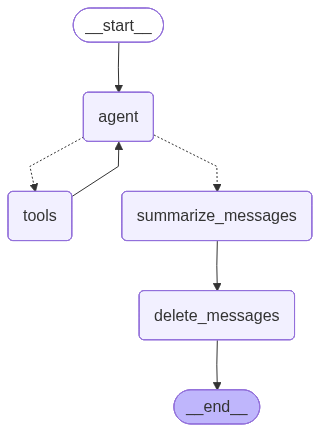

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

- `checkpointer`를 사용하는 경우, 관리를 위해 `thread_id`를 사용합니다

In [20]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'thread1'
    }
}

query = 'seungju41625886@gmail.com으로 청년월세지원 신청조건에 대한 내용을 요약해서 메일의 초안을 작성해주세요.'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

seungju41625886@gmail.com으로 청년월세지원 신청조건에 대한 내용을 요약해서 메일의 초안을 작성해주세요.
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_sqru2fUUh5tKM6O3lqjcYHFT)
 Call ID: call_sqru2fUUh5tKM6O3lqjcYHFT
  Args:
    query: 청년월세지원 신청조건
================================= Tool Message =================================
Name: real_estate_tax_retriever

2025년 서울시 청년월세지원 모집 공고
서울시에서는 “서울특별시 청년주거 기본 조례 제7조”에 의거 청년의 주거비 부담 완화를 위해 다음과 같이 2025년 '서울시 청년월세지원 사업' 참여자를 모집하오니 많은 참여 바랍니다.
2025년 6월 4일
서울특별시장
1. 사업 개요

사업명: 2025년 서울시 청년월세지원 사업
지원대상: 신청일 기준 서울시 월세 거주, 19세~39세 이하 청년 1인 가구
  ※ 서울시 청년월세지원 기수혜자 및 국토교통부 청년희망시스템 특례지원 수혜 중인 자, '25년 자치구 자체 청년월세지원 사업(운평, 광진 등) 지원자로 선정된 사람은 지원 불가

지원내용

지원금액: 월 최대 20만원(최대 12개월/240만원) ※ 생애 1회  
20만원 미만 월세 계약은 임대차계약서에 표기된 월세 금액만 지원(천원 단위 절삭 예시 차임) 108,000원 이상은 10만원 지원/ 관리비가 포함된 경우 관리비를 제외하고 월세만 지원
서울형 주택바우처 수급자인 경우, 바우처 수급액을 제외한 차

In [18]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 432, 'prompt_tokens': 3158, 'total_tokens': 3590, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'id': 'chatcmpl-D0UGxlwYFLeWZCEelqmRuwil5Hsth', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019be123-3202-7ac2-8674-54befc86dd85-0', tool_calls=[{'name': 'create_gmail_draft', 'args': {'message': '안녕하세요,\n\n서울시 청년월세지원 신청 조건에 대해 요약하여 안내드립니다.\n\n1. **사업 개요**\n   - **사업명**: 2025년 서울시 청년월세지원 사업\n   - **지원대상**: 신청일 기준 서울시 월세 거주, 19세~39세 이하 청년 1인 가구\n   - **지원금액**: 월 최대 20만원(최대 12개월/240만원)\n\n2. **신청 접수**\n   - **신청기간**: 2025. 6. 11.(수) 10:00 ~ 6. 24.(화) 18:00\n   - **신청방법**: 서울주거포털

In [19]:
graph.get_state(config).values['summary']

'In the chat, a user requested a summary of the application conditions for the Seoul Youth Monthly Rent Support program to be drafted as an email to seungju41625886@gmail.com. The AI retrieved detailed information about the program, including eligibility criteria, application process, and selection methods. The program targets young individuals aged 19-39 living in Seoul, offering up to 240,000 KRW over 12 months. The application period is from June 11 to June 24, 2025, and selections are based on rent and income criteria. The AI then created an email draft summarizing these details, ready for review and sending.'

In [ ]:
# from langchain_core.messages import RemoveMessage

# for index, message in enumerate(current_message_list):
#     if index < len(current_message_list) - 1:
#         graph.update_state(config, {'messages': RemoveMessage(id=message.id)})

In [ ]:
# current_message_list = graph.get_state(config).values['messages']
# current_message_list

In [21]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'thread1'
    }
}

update_query = '메일의 가장 위에 메일의 주제를 포함시켜주세요. 그리고 메일을 전송해주세요.'
for chunk in graph.stream({'messages': [HumanMessage(update_query)]}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

메일의 가장 위에 메일의 주제를 포함시켜주세요. 그리고 메일을 전송해주세요.
================================== Ai Message ==================================
Tool Calls:
  send_gmail_message (call_VhWPSLZggP1LDXLq9vfuKXbw)
 Call ID: call_VhWPSLZggP1LDXLq9vfuKXbw
  Args:
    message: 안녕하세요,

서울시 청년월세지원 신청 조건에 대해 요약하여 안내드립니다.

**메일 주제: 서울시 청년월세지원 신청조건 안내**

1. **사업 개요**
   - **사업명**: 2025년 서울시 청년월세지원 사업
   - **지원대상**: 신청일 기준 서울시 월세 거주, 19세~39세 이하 청년 1인 가구
   - **지원금액**: 월 최대 20만원(최대 12개월/240만원)

2. **신청 자격요건**
   - 주민등록상 신청인 1인만 등록되어 있는 무주택자 청년 1인 가구
   - 서울에 주민등록이 되어 있고 실제 거주하는 청년
   - 외국인은 신청 불가, 재외국민은 건강보험 가입자 또는 피부양자일 경우 신청 가능

3. **신청접수**
   - **신청기간**: 2025. 6. 11.(수) 10:00 ~ 6. 24.(화) 18:00
   - **신청방법**: 서울주거포털 온라인 신청

4. **선정 및 지급**
   - **선정방법**: 임차보증금-월세 및 소득기준 4개 구간으로 나누어 선정
   - **지급방법**: 각월 25일 전후로 계좌 입금

5. **기타**
   - 최종 선정 후 자격 유지 확인(심사) 후 지급
   - 자세한 사항은 서울주거포털 공지사항 참조

더 궁금한 사항이 있으시면 언제든지 문의해 주세요.

감사합니다.
    to: seungju4

In [22]:
graph.get_state(config).values['summary']

"In the chat, the user requested an email draft summarizing the application conditions for the Seoul Youth Monthly Rent Support program. The AI provided detailed information about the 2025 program, including eligibility criteria, application process, and selection methods. An email draft was created and prepared for sending to seungju41625886@gmail.com, including key details such as the program's name, target audience, support amount, application period, and method, as well as selection and payment procedures. The AI confirmed the draft's readiness and sent the email after including the subject at the top, as requested by the user."

In [ ]:
# send_query = '이메일을 전송해주세요'
# for chunk in graph.stream({'messages': [HumanMessage(send_query)]}, config=config, stream_mode='values'):
#     chunk['messages'][-1].pretty_print()